# Predicting the rank of Starcraft II players

**Ethan Shapiro**

## Summary of Findings


### Introduction
**Our Questions:** Can we predict a Starcraft player's rank based on their past ranked performance? If so, what information is useful and or will be useful to collect for future prediction?

**Type of Prediction Problem:** We're doing a multiclass classification on the player's rank.

**Response Variable:** Finding a solution to these problems I see could help us a few ways:

*From a gamer maker perspective*
1. Placing veteran players in the new ranked season
2. Placing new players into their first ranked league
3. Working in conjunction with another model to adjust ranks (ranked reset, rank inflation adjustments, etc.)

*From an esports organization perspective*
1. Evaluating if the player is "meant" to be in the rank they are at
2. Understanding what is important to be a higher tier player to help our player's improve 

**Metric:** I chose accuracy for evaluating the model because we want to weigh false positives and false negatives equally in our outcomes.

### Cleaning and Exploratory Data Analysis

We performed cleaning on 3 different complainant columns:
 - ethnicity
    - There were missing ethnicities labeled as "Unknown", so we changed those to NaN
    - We were not working with ethnicities, so there was no reason to impute these values
 - gender
    - There were missing genders labeled as "Unknown", so we changed those to be NaN
    - We were not working with genders, so there was no reason to impute these values
 - age
    - There were negative or 0 ages which aren't possible, so we changed those to NaN
    - We did not impute these values because we did not use them to answer our question in the beginning
    - There were also ages which were 5 or less, but we can't say for certain someone that age didn't make a complaint, so we didn't change those values.
 
 Since ethnicity, gender, and age are all reported by the complainant, they can choose not to give this information, which is why certain
 complaints do not include these attributes.

Next, we engineered two different features:
   - Duration the complaint was open
      - We used the complaint received date and the complaint closed date to get the number of days the complaint was open
   - Complaint Outcome
      - We used the original complaint outcome which contained a lot of sub-categories. We removed those categories and simplified it to either an action taken or not.

### Baseline Model
For our baseline model, we chose to use a **Decision Tree Classifier**.

We included these features:
 - **Officer Age at the incident (mos_age_incident)**
    - Type: Quantitative
    - Encoding: None
 - **Officer Ethnicity (mos_ethnicity)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Officer Gender (mos_gender)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Complainant Ethnicity (complainant_ethnicity)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Complainant Gender (complainant_gender)**
    - Type: Categorical
    - Encoding: One Hot Encoding
 - **Complainant Age (complainant_age_incident)**
    - Type: Quantitative
    - Encoding: None
 - **Type of Complaint (fado_type)**
    - Type: Categorical
    - Encoding: One Hot Encoding
    
We were trying to predict: **Outcome of Complaint (complaint_outcome)**

Our Basic Model's performance was:
 - Test accuracy: ~0.4944
 - Test precision: ~0.4628
 
We don't believe our model is good because it doesn't do significantly better than simply randomly guessing an outcome (which would be ~33%).<br>
There is no point to telling a complainant a possible outcome if we are not even 50% sure of our prediction.

### Final Model
For our final model, we stuck with a **Decision Tree Classifier**.

We feature engineered the following:
 - **Officer is a Minority**
    - *Type:* Categorical/Binary
    - *Encoding:* Returning any ethnicity non-white as a 1 and white as a 0.
    - *Why it's a good fit:* We believe there could be bias in the CCRB decision process based on ethnicity. Therefore, knowing if an officer is a minority might give information about the outcome of the complaint.
 - **Complainant is a Minority**
    - *Type:* Categorical/Binary
    - *Encoding:* Returning any ethnicity non-white as a 1 and white as a 0.
    - *Why it's a good fit:* We believe there could be bias in the CCRB decision process based on ethnicity. Therefore, knowing if a complainant is a minority might give information about the outcome of the complaint.
 - **Officer is a High Rank**
    - *Type:* Categorical/Binary
    - *Encoding:* Returning 1 for Deputy Inspector, Inspector, and Chief/other high ranks. Returning 0 otherwise.
    - *Why it's a good fit:* Higher ranking officers might have more favorable outcomes than lower ranking officers. Therefore, knowing if the rank is a high rank can help us predict the outcome.
 - **General Allegation Type**
    - *Type:* Categorical
    - *Encoding:* We take the original 76 unique allegation types and categorize them into 11 general groups. Then, we were able to One Hot Encode them.
    - *Why it's a good fit:* We believe the severity of the complaint will give information about the outcome of the complaint. I.E. More severe complaint allegations might be more likely to be Substantiated and vice-versa.
 - **General Outcome Type**
    - *Type:* Categorical/Ordinal
    - *Encoding:* We generalized the original outcome types into three major types: Arrest, Summons, or No Arrest. Then, we ordinally encoded it, making Arrest the most severe outcome, followed by Summons, and then No Arrest.
    - *Why it's a good fit:* We believe the outcome of the Officer and Complainant interaction can influence the decision of the CCRB. I.E. If someone is arrested during the interaction, their complaint might be out of spite and not necessarily true.

After creating these features, we ran a **GridSearchCV** with a **Decision Tree**, **5 folds**, and fitted on **75%** of the original data. We ended up with the following best hyperparameters:
 - criterion: entropy
 - max_depth: 12
 - min_samples_split: 15

Our Final Model's performance was:
 - Test accuracy: ~0.5349
 - Test precision: ~0.5408

This means our model improved its accuracy by ~4.05% and its precision by ~7.80%.

### Fairness Analysis

We ran a permutation Tests to test our model's **precision** of Minority vs. Non-Minority Complainants with the following hypotheses:

<b>Null Hypothesis:</b> Our model is fair. Its precision for minorities and non-minorities are roughly the same, and differences are due to random chance.

<b>Alternative Hypothesis:</b> Our model is unfair. Its precision for minorities is better than for minorities than non-minorities.

<b>Evaluation Metric:</b> Precision

<b>Our signifcance value:</b> 0.05

With a p-value = 0.013 < 0.05, we reject the null hypothesis and say that our model is unfair.
Our model has worse precision for complainants that are non-minorities than it does for minorities.

---
## Imports

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

----
## Cleaning and EDA

In [96]:
# Read in the data
df = pd.read_csv('starcraft_player_data.csv')
df.head(1)

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.718,0.003515,0.00022,7,0.00011,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.0


In [97]:
# See if we have any missing values
df.isna().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [98]:
# Seems to be no missing values, but let's take a look at our column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

We expect the Age, Hours per week, and Total Hours to be numeric types, so let's check those columns to see if anything is out of place

In [99]:
# Age, HoursPerWeek, and TotalHours have ?'s in place for missing values
unique_ages = df['Age'].unique()
non_numeric_ages = [not x.isnumeric() for x in unique_ages]
print(f"Non-numeric entries in 'Age': {unique_ages[non_numeric_ages]}")
num_non_numeric_entries = df[df['Age'].isin(unique_ages[non_numeric_ages])].shape[0]
print(f"Number of Ages with '?': {num_non_numeric_entries}")

unique_hrsperweek = df['HoursPerWeek'].unique()
non_numeric_hrsperweek = [not x.isnumeric() for x in unique_hrsperweek]
print(f"Non-numeric entries in 'HoursPerWeek': {unique_hrsperweek[non_numeric_hrsperweek]}")
num_non_numeric_entries = df[df['HoursPerWeek'].isin(unique_hrsperweek[non_numeric_hrsperweek])].shape[0]
print(f"Number of HoursPerWeek with '?': {num_non_numeric_entries}")
 
unique_totalhrs = df['TotalHours'].unique()
non_numeric_totalhrs = [not x.isnumeric() for x in unique_totalhrs]
num_non_numeric_entries = df[df['TotalHours'].isin(unique_totalhrs[non_numeric_totalhrs])].shape[0]
print(f"Non-numeric entries in 'TotalHours': {unique_totalhrs[non_numeric_totalhrs]}")
print(f"Number of TotalHours with '?': {num_non_numeric_entries}")

Non-numeric entries in 'Age': ['?']
Number of Ages with '?': 55
Non-numeric entries in 'HoursPerWeek': ['?']
Number of HoursPerWeek with '?': 56
Non-numeric entries in 'TotalHours': ['?']
Number of TotalHours with '?': 57


Replace '?' with NaN

In [100]:
df.loc[:, ['Age', 'HoursPerWeek', 'TotalHours']] = df[['Age', 'HoursPerWeek', 'TotalHours']].apply(lambda x: x.replace('?', np.NaN).astype(np.float64))

# we can verify we replaced the '?'s correctly
df[['Age', 'HoursPerWeek', 'TotalHours']].isna().sum()

Age             55
HoursPerWeek    56
TotalHours      57
dtype: int64

Before we consider removing these rows/columns, let's explore each of them to determine whether we can impute the values based on other columns.

First, we we'll take a look at the distribution of missingness among our target variable, League Index.

In [101]:
df[df['Age'].isna()]['LeagueIndex'].value_counts()

LeagueIndex
8    55
Name: count, dtype: int64

The missing ages are all from the League 8, which means that the missingness is likely Not Missing At Random (NMAR). It was likely left out by choice during the data collection process and therefore will probably be absent from future data collection processes.

Before I completely remove Age column, I'll take a look at the distribution of Age in terms of the player's rank. If there isn't any significant trend, it's safe to say removing the Age column won't affect the model. 

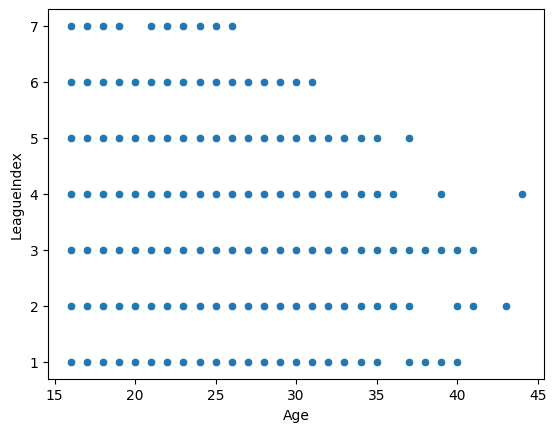

In [102]:
sns.scatterplot(df, x='Age', y='LeagueIndex')
plt.show()

Since the above scatterplot shows that Rank doesn't seem to have an association with Age, we'll remove that column.

In [103]:
df = df.drop(['Age'], axis=1)

Next, let's take a look at the 'HoursPerWeek' column and how that relates to our player's rank.

In [109]:
df.groupby(['LeagueIndex'])[['HoursPerWeek']].agg(['min', 'max', 'mean'])

HoursPerWeek                  
                     min    max       mean
LeagueIndex                               
1                    2.0   70.0  13.125749
2                    2.0   72.0   13.29683
3                    2.0   80.0  13.949367
4                    2.0   96.0  14.022195
5                    2.0   96.0  16.183851
6                    0.0  168.0  21.088567
7                    6.0   98.0  31.714286
8                    NaN    NaN        NaN

<Axes: >

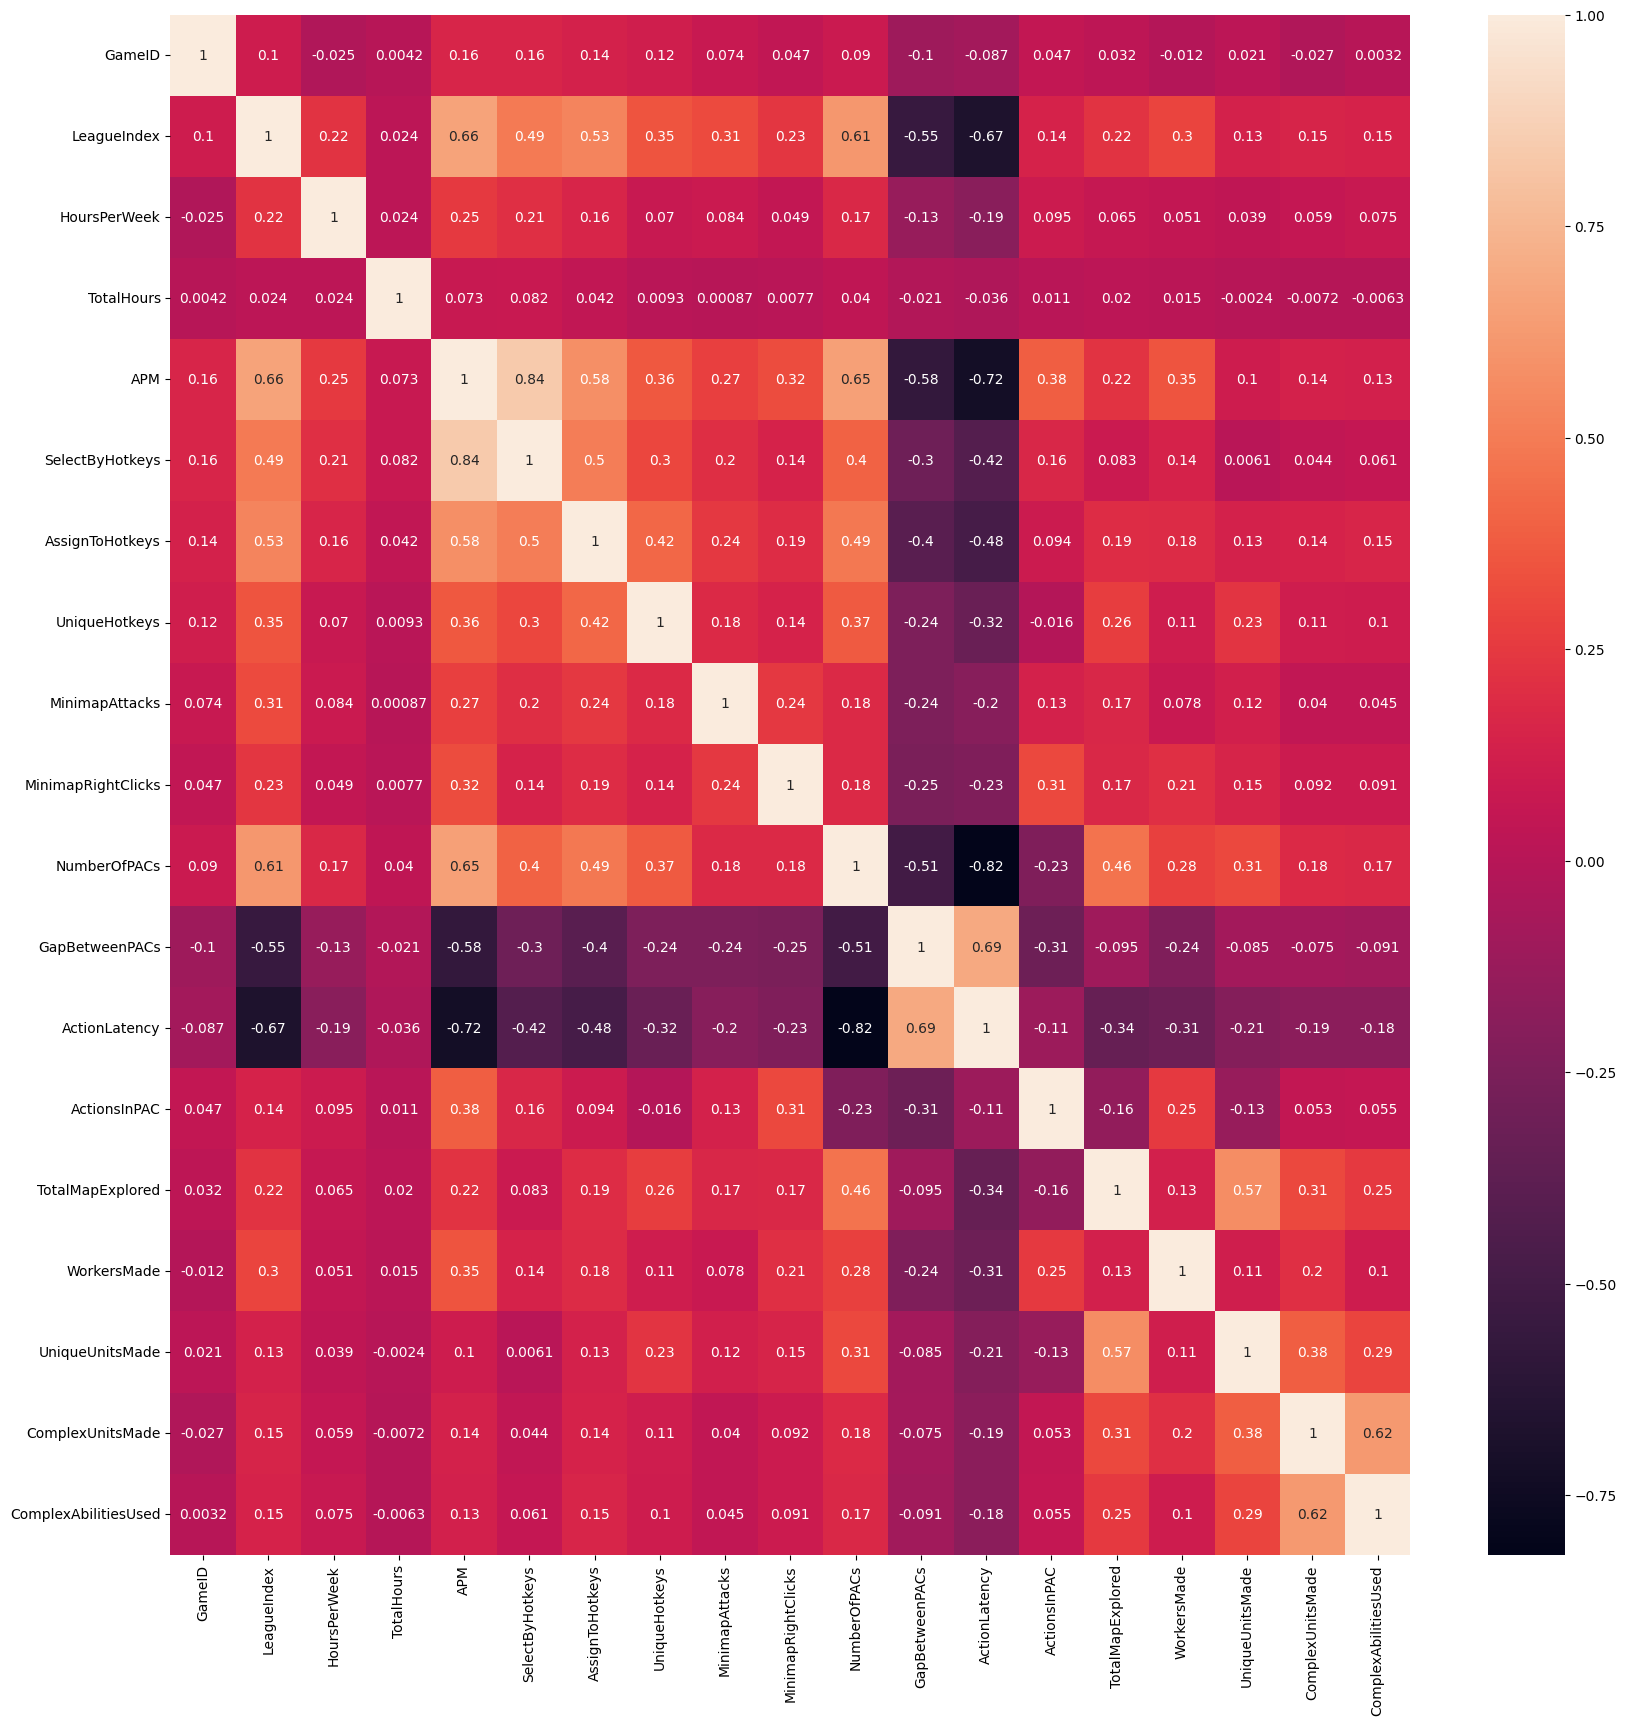

In [113]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True)

In [114]:
from sklearn.preprocessing import StandardScaler

In [120]:
scaled_data = df.copy(deep=True)
scaled_data.iloc[:, 4:] = StandardScaler().fit_transform(scaled_data.iloc[:, 4:])

<Axes: >

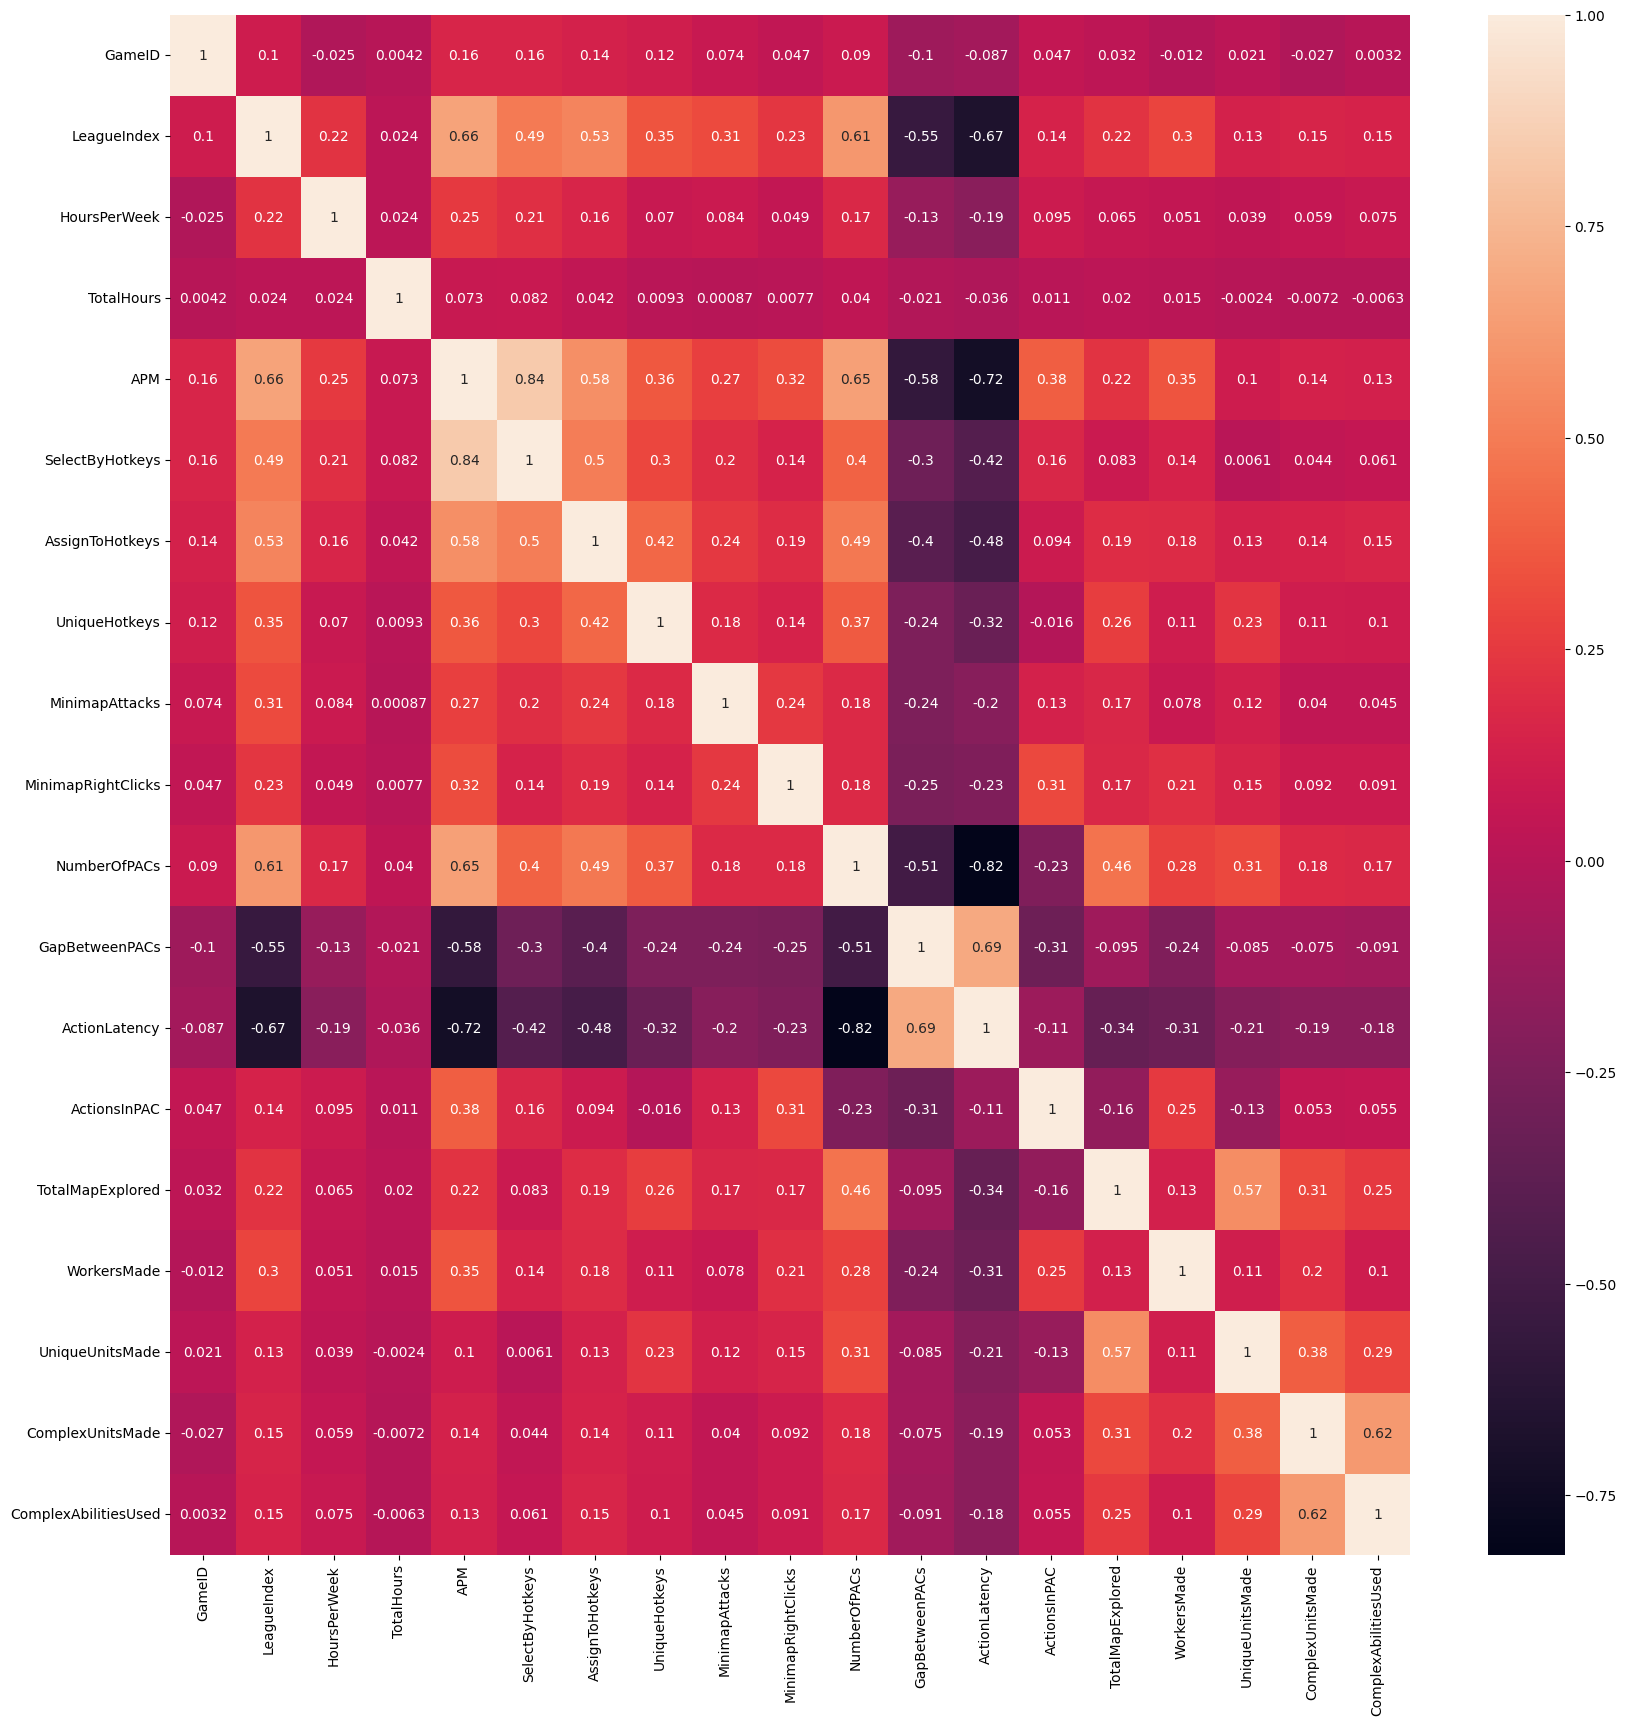

In [123]:
plt.figure(figsize=(20, 20))
sns.heatmap(scaled_data.corr(), annot=True)


Now, I'll take a look at 'HoursPerWeek' missingness now.
We only have one player with 'HoursPerWeek' missing that isn't in League 8

In [11]:
df.loc[((df['HoursPerWeek'].isna()) & (df['LeagueIndex'] != 8)), :]

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
1841,5255,5,18.0,NaN,NaN,122.247,0.006357,0.000433,3,0.000014,0.000257,0.003043,30.8929,62.2933,5.3822,23,0.001055,5,0.0,0.000338


In [12]:
df[(df['LeagueIndex'] == 5) & (df['Age'] == 18)]['HoursPerWeek'].median()

22.0

<Axes: xlabel='APM', ylabel='TotalHours'>

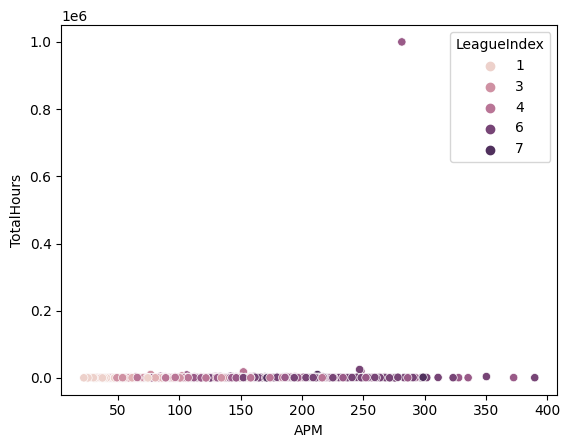

In [19]:
sns.scatterplot(df, x='APM', y='TotalHours', hue='LeagueIndex')

In [25]:
test_df = df[~df['HoursPerWeek'].isna()]

In [26]:
hrs_per_week = test_df['HoursPerWeek']

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


In [55]:
X = test_df.iloc[:, 5:]

<Axes: xlabel='APM', ylabel='HoursPerWeek'>

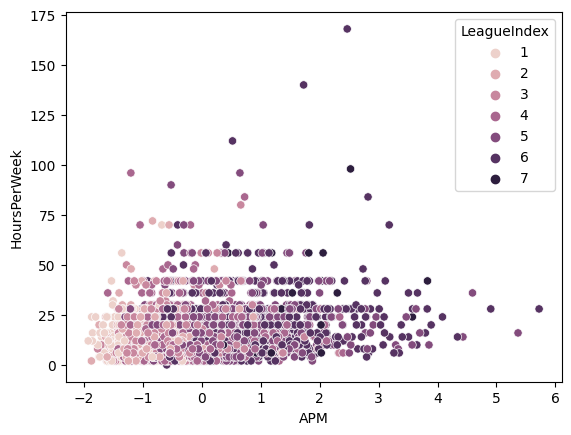

In [56]:
sns.scatterplot(test_df, x='APM', y='HoursPerWeek', hue='LeagueIndex')

In [32]:
X = StandardScaler().fit_transform(X)

In [49]:
test_df.iloc[:, 5:] = X

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, hrs_per_week, test_size=0.33, random_state=200)

In [44]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_preds = lm.predict(X_test)

In [48]:
lm_preds

array([21.09279597, 17.07373417, 11.30106887, ..., 11.12506123,
       20.25945323, 20.56137505])

In [45]:
y_test

2155    28.0
131     10.0
2274     8.0
1361     4.0
1194     8.0
        ... 
2825    14.0
526      6.0
3137     2.0
2292    30.0
3085     6.0
Name: HoursPerWeek, Length: 1102, dtype: object

In [46]:
svm = SVR()
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

In [47]:
svm_preds

array([16.74838317, 12.57041728, 10.32152488, ...,  9.05043232,
       16.17418977, 16.04972737])

In [58]:
dtree_r = DecisionTreeRegressor()
dtree_r.fit(X_train, y_train)
tree_preds = dtree_r.predict(X_test)

In [63]:
err = np.square(y_test - tree_preds) / 1102

<Axes: xlabel='HoursPerWeek', ylabel='Count'>

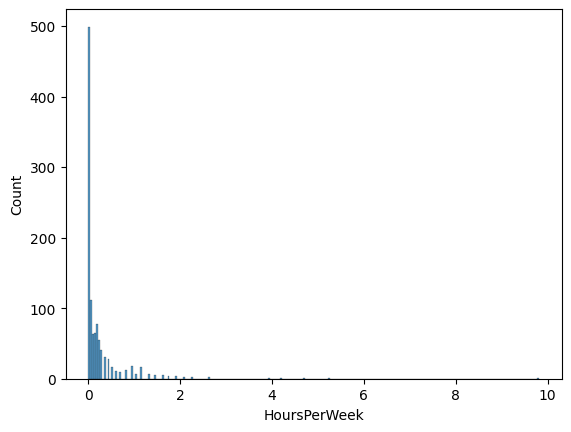

In [64]:
sns.histplot(err)